In [ ]:
ls

In [ ]:
ls USE4

In [11]:
import tensorflow as tf
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
import tensorflow_hub as hub

In [10]:
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score
import os
import csv
import string
from numpy.random import RandomState
import urllib.parse
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

In [18]:
embeddings=hub.load(r'.\USE4')

In [17]:
df_train=pd.read_csv('train.txt')

In [19]:
df_train

,tweet_id,sentiment,tweet_text
0,264183816548130816,positive,Gas by my house hit $3.39!!!! I\u2019m going t...
1,263405084770172928,negative,Theo Walcott is still shit\u002c watch Rafa an...
2,262163168678248449,negative,its not that I\u2019m a GSP fan\u002c i just h...
3,264249301910310912,negative,Iranian general says Israel\u2019s Iron Dome c...
4,262682041215234048,neutral,Tehran\u002c Mon Amour: Obama Tried to Establi...
...,...,...,...
21460,522949024132112384,neutral,"the day after newark ill be able to say """"i me..."
21461,522372593312350209,neutral,FEC hold farewell session for seven ministers ...
21462,522515200592052224,neutral,Luca Di Montezemolo (who's last day was Monday...
21463,523089087155437568,positive,Coffee is pretty much the answer to all questi...


In [12]:
def url_parser(string):
  new_string = ''
  for i in string.split():
     s, n, p, pa, q, f = urllib.parse.urlparse(i)
     if s and n:
         pass
     elif i[:1] == '@':
         pass
     elif i[:1] == '#':
         new_string = new_string.strip() + ' ' + i[1:]
     else:
         new_string = new_string.strip() + ' ' + i
  return new_string

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)


In [20]:
corpus=[]
from tqdm import tqdm
for i in tqdm(range(0,df_train.shape[0])):
    text=df_train['tweet_text'][i]
    text=url_parser(text)
    #print(text)
    text=re.sub('[^a-zA-Z]',' ',text)
    #print(text)
    text=re.sub(r"http\S+", "", text)
    #print(text)
    text=text.lower()
    #print(text)
    text=emoji_pattern.sub(r'', text)
    #print(text)
    text=text.split()
    #print(text)
    lemmatizer = WordNetLemmatizer()
    text=[lemmatizer.lemmatize(word,pos ="a") for word in text if not word in set(stopwords.words('english'))]
    #print(text)
    #ps=PorterStemmer()
    #text=[ps.stem(word) for word in text if not word in set(stopwords.words('english'))]
    #print(text)
    text=' '.join(text)
    #print(text)
    corpus.append(text)

100%|███████████████████████████████████████████████████████████████████████████| 21465/21465 [01:51<00:00, 193.12it/s]


In [21]:
vec_embeddings=[]
for text in tqdm(corpus):
    vector=tf.make_ndarray(tf.make_tensor_proto(embeddings([text]))).tolist()
    vec_embeddings.append(vector)

100%|███████████████████████████████████████████████████████████████████████████| 21465/21465 [02:32<00:00, 140.37it/s]


In [22]:
vec_embeddings_arr=np.array(vec_embeddings).reshape(21465,512,1)

In [23]:
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder()
labels=ohe.fit_transform(df_train['sentiment'].values.reshape(-1,1)).todense()

In [24]:
labels=np.array(labels)

In [13]:
def UniversalEmbedding(x):
    return embeddings(tf.squeeze(tf.cast(x, tf.string)))

In [25]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(vec_embeddings_arr,labels,test_size=0.1)

In [15]:
vector_size=512
batch_size=128
num_epochs=100

In [16]:
from keras.models import Sequential
from keras.layers import Conv1D,Dropout,Dense,Flatten,LSTM,MaxPooling1D,Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,TensorBoard

In [17]:
from kerastuner.tuners import RandomSearch

In [18]:
from kerastuner import HyperModel

In [19]:
class nlp_model(HyperModel):
    def __init__(self,classes):
        self.classes=classes
    
    def build(self,hp):
        model=Sequential([Conv1D(filters=hp.Int('Conv_Layer_1',min_value=32,max_value=96,step=16),kernel_size=hp.Choice('conv_1_kernel',values=[3,5]),activation='relu',padding='same',input_shape=(vector_size,1)),
                         Conv1D(filters=hp.Int('Conv_Layer_2',min_value=32,max_value=96,step=16),kernel_size=hp.Choice('conv_2_kernel',values=[3,5]),activation='relu',padding='same',input_shape=(vector_size,1)),
                         MaxPooling1D(pool_size=hp.Choice('max_pool_kernel',values=[3,5])),
                         Bidirectional(LSTM(512, dropout=0.2, recurrent_dropout=0)),
                         Dense(512, activation='relu'),
                         Dropout(0.25),
                         Dense(units=hp.Int('dense2_units',
                                            min_value=96,
                                            max_value=512,
                                            step=32), activation='sigmoid'),
                          
                         Dropout(0.35),
                         Dense(units=hp.Int('dense3_units',
                                            min_value=96,
                                            max_value=512,
                                            step=32), activation='sigmoid'),
                         
                         Dense(self.classes, activation='softmax'),
                         ])
        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-4])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
        return model

In [20]:
hypermodel=nlp_model(classes=3)

In [43]:
tuner=RandomSearch(hypermodel,objective='val_accuracy',max_trials=6,
                  directory='my_dir',project_name='nlp_project')

INFO:tensorflow:Reloading Oracle from existing project my_dir\nlp_project\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\nlp_project\tuner0.json


In [49]:
tuner.search(x_train,y_train,epochs=5,validation_data=(x_test,y_test))

INFO:tensorflow:Oracle triggered exit


In [27]:
tuner.get_best_models(num_models=1)[0]

In [ ]:
model.save('Best_model_by_fine_tuning')

In [ ]:
model.summary()

# Testing

In [8]:
df_test=pd.read_csv('test_samples.txt')

In [ ]:
df_test

In [13]:
test_corpus=[]
from tqdm import tqdm
for i in tqdm(range(0,df_test.shape[0])):
    text=df_test['tweet_text'][i]
    text=url_parser(text)
    #print(text)
    text=re.sub('[^a-zA-Z]',' ',text)
    #print(text)
    text=re.sub(r"http\S+", "", text)
    #print(text)
    text=text.lower()
    #print(text)
    text=emoji_pattern.sub(r'', text)
    #print(text)
    text=text.split()
    #print(text)
    lemmatizer = WordNetLemmatizer()
    text=[lemmatizer.lemmatize(word,pos ="a") for word in text if not word in set(stopwords.words('english'))]
    #print(text)
    #ps=PorterStemmer()
    #text=[ps.stem(word) for word in text if not word in set(stopwords.words('english'))]
    #print(text)
    text=' '.join(text)
    #print(text)
    test_corpus.append(text)

100%|█████████████████████████████████████████████████████████████████████████████| 5398/5398 [00:27<00:00, 193.13it/s]


In [14]:
test_vec_embeddings=[]

for text in tqdm(test_corpus):
    vector=tf.make_ndarray(tf.make_tensor_proto(embeddings([text]))).tolist()
    test_vec_embeddings.append(vector)

100%|█████████████████████████████████████████████████████████████████████████████| 5398/5398 [00:38<00:00, 141.47it/s]


In [15]:
test_vec_embeddings_arr=np.array(test_vec_embeddings).reshape(5398,512,1)

In [31]:
reconstructed_model = keras.models.load_model("Best_model_by_fine_tuning")

In [32]:
history=reconstructed_model.fit(
    x=x_train, y=y_train, batch_size=50, epochs=10, verbose=1, callbacks=None,
    validation_split=0.0, validation_data=(x_test,y_test))

Epoch 1/10
387/387 [==============================] - 19s 50ms/step - loss: 0.9098 - accuracy: 0.5504 - val_loss: 0.9143 - val_accuracy: 0.5575
Epoch 2/10
387/387 [==============================] - 19s 49ms/step - loss: 0.9047 - accuracy: 0.5520 - val_loss: 0.9232 - val_accuracy: 0.5459
Epoch 3/10
387/387 [==============================] - 19s 49ms/step - loss: 0.9013 - accuracy: 0.5567 - val_loss: 0.9130 - val_accuracy: 0.5519
Epoch 4/10
387/387 [==============================] - 19s 49ms/step - loss: 0.8989 - accuracy: 0.5565 - val_loss: 0.9117 - val_accuracy: 0.5491
Epoch 5/10
387/387 [==============================] - 19s 50ms/step - loss: 0.8953 - accuracy: 0.5594 - val_loss: 0.9179 - val_accuracy: 0.5487
Epoch 6/10
387/387 [==============================] - 19s 50ms/step - loss: 0.8909 - accuracy: 0.5610 - val_loss: 0.9092 - val_accuracy: 0.5599
Epoch 7/10
387/387 [==============================] - 19s 50ms/step - loss: 0.8869 - accuracy: 0.5652 - val_loss: 0.9057 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


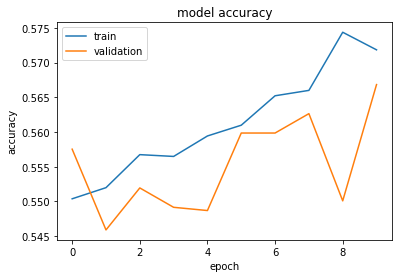

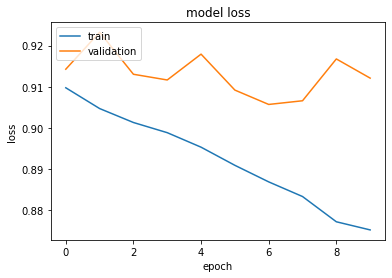

In [33]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [7]:
from keras.utils import plot_model

In [ ]:
predictions=reconstructed_model.predict(test_vec_embeddings_arr)

In [ ]:
predictions=np.argmax(predictions,axis=1)

In [ ]:
np.unique(pred_df.sentiment.values,return_counts=True)

In [ ]:
#010 neutral,001 positive,100 negative

In [ ]:
pred_dict={'0':'negative','1':'neutral','2':'positive'}

In [ ]:
transforms=[]
for preds in predictions:
    transforms.append(pred_dict[str(preds)])

In [ ]:
pred_df=pd.DataFrame({'tweet_id':df_test['tweet_id'].values,'sentiment':transforms})

In [ ]:
pred_df.to_csv('submission_USE4.csv',index=False)